# Temporal Dynamics in Music Source Separation: A Time Series Perspective
### A Time Series Analysis of Music Source Separation Models
**PSTAT 174 Time Series Final Project**

*Coby Wilcox, 4812764*

## Abstract

Music source separation (MSS), is the practice of taking a given mix of music and decomposing it into one or more separate audio files that each mean to 'separate' a target music source (bass, guitar, drums, vocals etc.) into their own audio files. Research for this particular field has been ongoing for decades[citations] and like many other fields has seen a massive leap in progress from the relatively recent developments with neural networks[citations]. In this study I created a number of source separation models and examined them using methods from time series analysis along with creating a SARIMA model of the music itself to better my understanding. The main ideas of my project will be split into 3 different main reports, one detailing the SARIMA model I made, one analyzing residuals of a basic MSS model using time series analysis, and one detailing the neural network MSS model I made trying to recreate the model detailed in this paper *Conv-TasNet: Surpassing Ideal Time-Frequency Magnitude Masking for Speech Separation*. In the end I was able to successfully recreate the model, however the results did not appear to be as impressive as they did in the original paper. My best guess to why this is, is that the to compensate for my lack of computing power I had to significantly change the format of training data. In the future I would like to refine my model and data pipeline to achieve the results originally published in the paper. 

In [1]:
import display # module for displaying results of analysis

## 1. Introduction

Isolated recordings of music tracks can be surprisingly hard to obtain, while often kept by the recording artist themself, as a independent musician or producer one will often need to resort to recording the part themself to obtain a good quality recording however, the equipment and skill required to do this may not be availible to your average consumer. Thus using a statistical machine learning model to obtain estimations of these recordings may be the next best thing for the general populace. Aside from using an isolated track to simply learn how to play a song, a source separated song can be used in music production for sampling, and has been shown to aid other machine learning models trained for automatic music transcription, lyric recognition, singer/instrument identification, and fundamental frequency estimation to name a few. 

Recently there have been a number of new MSS models that achieve state-of-the-art results often times using very different techniques to achieve these results such as Demucs and Band-Split RNN. In this study however I chose to recreate a relatively less state-of-the-art MSS model called Conv-TasNet. Conv-TasNet published in 2017 and was actually made for the purpose of speech separation, however people found when applied to the task of MSS would achieve very impressive results. As a result several well known MSS's such as Demucs and Spleeter have been built using Conv-TasNet as a foundation. That is not to decry the complexity of Conv-TasNet however, as using its recommended hyperparameters is still a model with over 60 layers and 6 million weights. 

To help with my understanding of music source separation and my model I employed several time series analysis techniques to aid in my learning such as a seasonal autoregressive moving average model (SARIMA), residual analysis using signal analysis and auto correlation functions, spectral analysis using periodograms, cospectrums, and spectrograms.

## 2. Data

The data I used in this study was MUSDB-18, which is a dataset containing 150 songs with their mix audio tracks, isolated drums, bass, vocals and other sources audio tracks, and meta-information on the songs like name and artist. The songs of the dataset are all copyright-free, mostly being taken from the *Mixing Secrets- Free Multitrack Download Library*, though other songs have been taken from other free music libraries or donated by artists. The dataset is divided into training set of 100 songs and a test set of 50 songs. To parse the dataset, I used the `musdb` python package which can simply be installed with `! pip install musdb`. It should be noted however, that to be able to use the package one must also install `ffmpeg` and `stempeg`, which are libraries used to work with video and audio on python.

Generally each song was within the time range of 1:30 to 2:30 in duration and overall the dataset contained ~10 hours of music. When using the songs to train or test the neural network, I would generally split a song into batches where each observation is 400 samples long with batches of about 50. 

## 3. Methodology

### 3.1 SARIMA model

The SARIMA model is a time series model that consists of four main parts. It is a autoregressive model, that uses $p$ past observation values in this case samples to make a linear estimation of future values. Then to account for noise of past values applies a moving average of the last $q$ noise values. To make up for any non-stationarity of the data differencing can be applied to keep the data stationary, the order of differencing applied to get the data stationary is represented by $q$. Finally to make up for any seasonality of the data you can apply a sinal pattern to the model at a given frequency of $s$. Overall a SARIMA model can represented like this:

$$
\Phi_P(B^s) \phi_p(B) (1 - B)^d (1 - B^s)^D y_t = \Theta_Q(B^s) \theta_q(B) \epsilon_t
$$
Where:
$p$: order of the non-seasonal AR (AutoRegressive) part,
$d$: order of the non-seasonal differencing,
$q$: order of the non-seasonal MA (Moving Average) part,
$P$: order of the seasonal AR part,
$D$: order of the seasonal differencing,
$Q$: order of the seasonal MA part, and
$s$: length of the seasonal cycle.

### 3.2 Spectral Analysis

One of the most fundamental tools of spectral analysis is the short-time Fourier Transform, which is a wonderful mathematical function that allows us to decompose a summation of signals into its individual signals. Generally the Fourier Transform is applied to windowed overlapping chunks of a time series data, of some length that is power 2 for computational reasons. The Fourier Transform in all its glory can be represented like this:

$$d(\omega_j) = \frac{1}{\sqrt{n}}\sum_{t=1}^{n}{x_t \cdot e^{-2\pi i\omega_j t}}$$

Where $x_t$ are the $n$ lengthed, windowed overlapping frames of the audio signal, and $\omega_j$ are the frequencies.

We can then directly use this calculation to create our periodograms which are a measure of the contribution of a frequency within a signal

$$|d(\omega_j)|^2=I(\omega_j) = \sum_{h=-(n-1)}^{n-1}{\hat{\gamma}(h) \cdot e^{-2\pi i\omega_j h}}$$

Where $\hat{\gamma}(h)$ is the sample autocorrelation, and $\omega_j$ are the frequencies.

Lastly, many of my visualizations are spectrograms which aren't a concept we talked about in Time Series however they are a very close relative to these two concepts. Essentially when you place each of these overlapping chunks periodograms chronologically with frequencies as the y-axis and color them based on the level of spectral density of a frequency you get a spectrogram which is one of the most intuitive ways you can visualize a piece of music. 

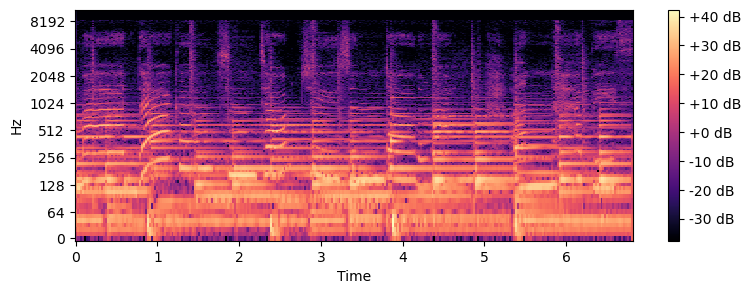

In [2]:
display.spectrogram() # example spectrogram

### 3.3 Neural Network

Neural networks are an idea that are hard to express verbally, but in essence they are a non-linear model that is based on passing data through nodes or neurons that each have some mathematical function attached (typically just being multiplied by some weight) to the neuron. The data will often pass through multiple layers of these neurons until being it outputs some estimate of its target. To which, using a process called backpropogation, the parameters of the model are adjusted to output something closer to the target. The most basic type of layer in a neural network is called a dense layer. The dense layer connects every single neuron in the base layer to a weight to form a weighted some calculation for a neuron's activation in this next dense layer. 

For the mathematical notation note that:
- $i$ denotes amount of neurons in the previous layer
- $j$ denotes amount of neurons to be made in this dense layer.
- $w_{ij}$ denotes the weight for the ith input into the jth output neuron.
- $b_j$ denotes the bias for the jth output neuron.
- ${x_i}$ denotes the set of input values from the previous layer
- ${y_j}$ denotes the set of output values from this dense layer.

You can write a given output as: $y_j = x_1w_{1j} + ... + x_1w_{ij} + b_j$

However using matrix multiplication you can rewrite this as:
- $W_j$ denotes the $j$ x $i$ matrix that stores all the weight values for a output neuron.
- $b$ denotes a vector of bias terms.

$$Y = W_jX + b$$

### 3.4 Convolutions in a Neural Network:

Of course in Conv-TasNet we are mostly dealing with convolutional neural network layers. Inputs, denoted $X$, will be 3-dimensional objects that are almost like several pages of a book. Each page,$X_n$, is a matrix (probably a square matrix) and the amount of pages can be thought of as the depth, denoted $n$. The elements of the inputs represent activations for a given input. Each element denoted by: $$x_{i,j}^n \in X_n$$

The kernels object, denoted $K$, will be 4-dimensional, with a given kernel,$K_{dn}$, having $n$ 2d matrices to apply to each the matrix at each depth in the input, and then there can be multiple kernels in a kernel which each are denoted by $d$. The elements of kernels represent weights that are attached to the inputs to calculate a weighted sum. Weights denoted by: $$w_{i,j}^d \in K_{dn}$$

Then for each kernel the layer contains, a separate bias matrix, denoted $B_d$ will be added to the resulting weighted sums for each output. Elements denoted: $$b_{i,j}^d \in B_d$$

Finally to show how the full output matrix of the convolution layer, $Y_d$ is mathematically represented: 
$$Y_d = B_d + X_1 \star K_{1d} + ... + X_n \star K_{nd}$$

$$Y = B + X \cdot|\star K $$

## 4. Results

### 4.1 Results of SARIMA

The results of the SARIMA model were not very impressive. Generally what I learned from this process was that SARIMA models are not very apt at working with music files overall. I think this come down to few main problems. First the amount of 'observations' in an audio file is much larger than any average time series data, that typically will be modeled in days, months, or years, but this data is being modeled in every $\frac{1}{44100}$ of a second. This can add extreme computation times for a something like SARIMA, to address this I limited my data to only 5000 observations. This wasn't a enough to competely solve any issues I was having, as another problem with modeling music with SARIMA is the actual data itself. SARIMA models generally will be used for things like stocks, sales, population, things that generally have an overall trend, with a bit of noise, and possibly some level of seasonality. Music isn't really comprised of observations as it comprised of hundreds if not thousands of different sinal waves layered on top of each other. It's almost like instead of one seasonal trend in the data, there are hundreds of seasonal trends that should all be kept track of at the same time. 

That being said, to create the model I first loaded in a song from my dataset, subsetting the first 5000 samples, and then looking at the resulting plot. Due to the resulting ACF and PACF plots of the nontransformed data, I decided to applied a couple orders of differencing until the ACF and PACF plots looked more like noise. 

c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
c:\Users\cobyw\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


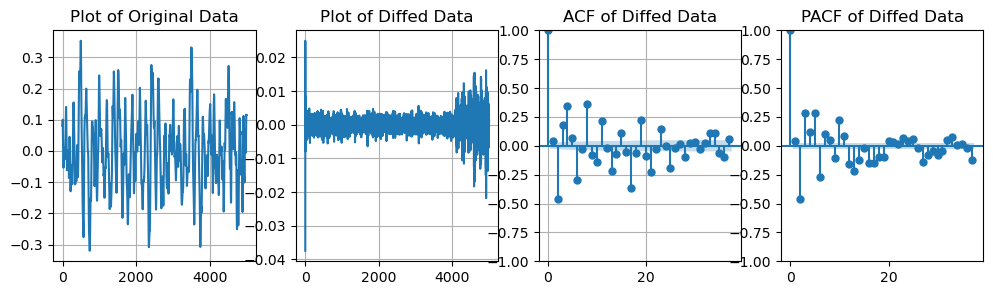

In [13]:
model,y = display.load_sarima(order=(9,2,7,3))

Using the ACF and PACF plots, I estimated my $p$ and $q$ parameters, by examining the lags sticking out of the significance zone. In the PACF I saw around 15 lags sticking out, and not wanting to have extreme computation times limited the $p$ parameter to 9. Following the same process except for the ACF, I set my $q$ to 7. Lastly to account for the seasonality of the data, I tried to find the most prevalent frequency in the data and set my $s$ parameter to that. By creating a periodogram I was able to see that the dominant frequency was ~129. However, I soon found out that setting $s$ parameters too high creates extrememly long computation times. To compensate I simply set $s$ to the lowest common divisor of the dominant frequency, to account for its prescence somewhat but not create too long of computation times. 

                                               SARIMAX Results                                               
Dep. Variable:                                                     y   No. Observations:                 5000
Model:             SARIMAX(1, 0, 0)x(9, 2, [1, 2, 3, 4, 5, 6, 7], 3)   Log Likelihood               21075.602
Date:                                               Thu, 13 Jun 2024   AIC                         -42115.204
Time:                                                       14:57:54   BIC                         -41997.916
Sample:                                                            0   HQIC                        -42074.094
                                                              - 5000                                         
Covariance Type:                                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------

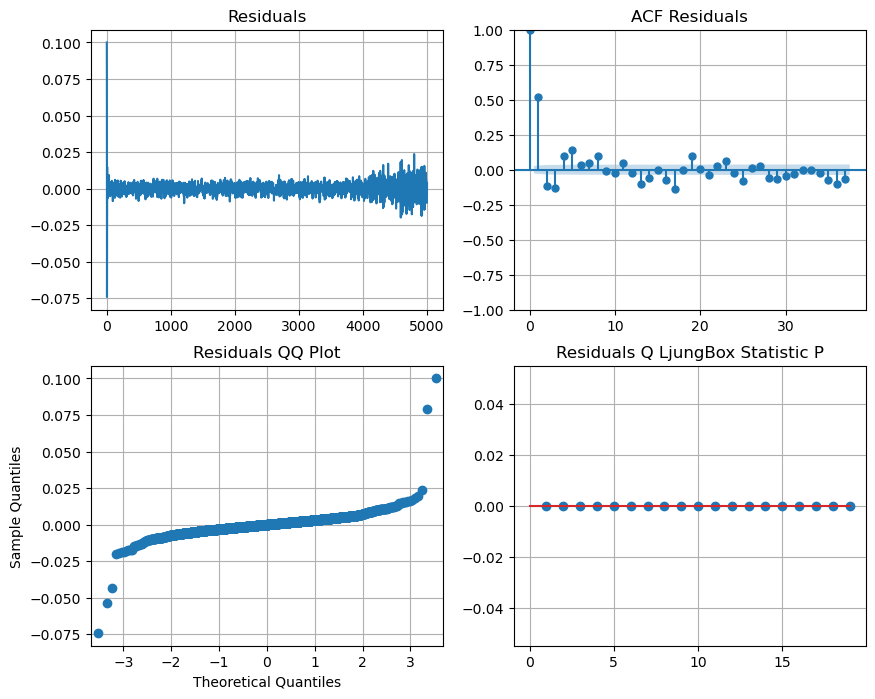

In [9]:
display.diagnostics(model)

Looking at the diagnostics, I was pleased to see the residuals seemed mostly to consist of noise and the residuals distribution appeared to be normal from the QQ plot. Also looking at the ACF of the residuals, it generally seemd to be normal. The Ljung Statistic was very low, low enough where I am somewhat suspicious if there is an issue with the way it is being calculated. Finally Given the reasons I laid out in the first paragraph, unsurprisingly the forecast of the data, was not very accurate. For any other details in the SARIMA model process, I recommend looking at my sarima_report, as it contains much more of the steps for the SARIMA model and my thought process going into them.

The process of fitting the SARIMA model and learning how to choose good parameters was a great experience overall, however what I learned quickly was for music data, this particular type of time series analysis leaves much to be desired. Thankfully I got a much better experience examining the data through spectral analysis which I go over in the next section.  

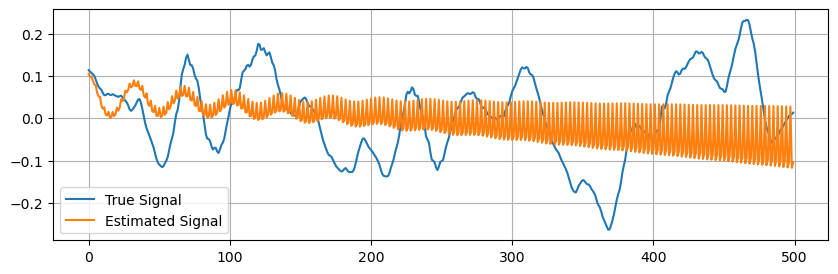

In [10]:
display.forecast(model, y)

### 4.2 Results Spectral Analysis

Performing spectral analysis was hugely successful for my project and my understanding of this field of research overall. After creating some source estimates using a very rudementary method, I first examined the overall plots of the residuals created from the estimates and their targets. Since the data appear to be sinal, I created smoothed periodograms under the instruction of Professor Ichiba. When these periodograms were paired with cross spectrum analysis for each model the results were very interesting. 

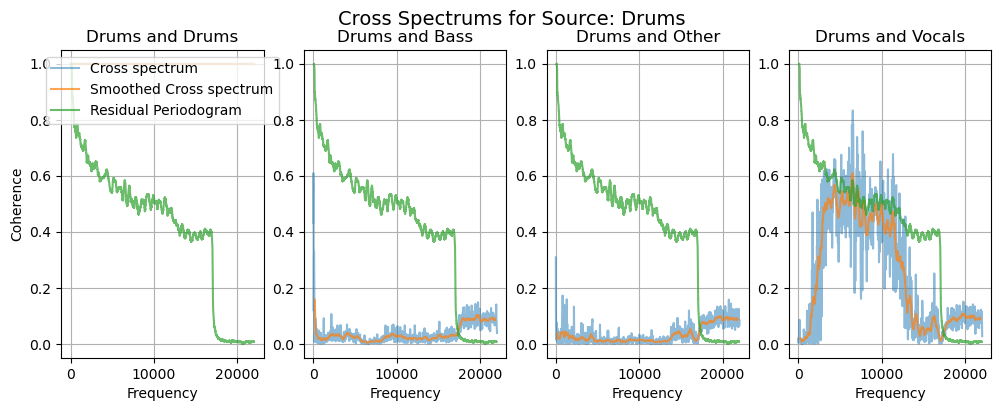

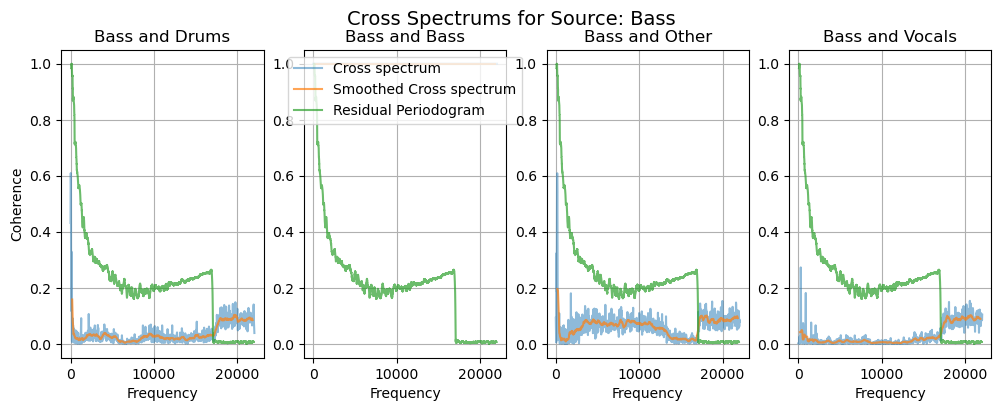

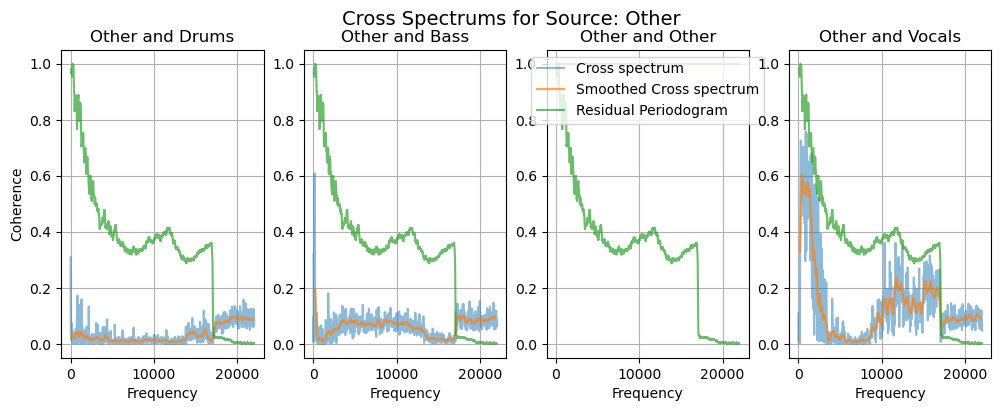

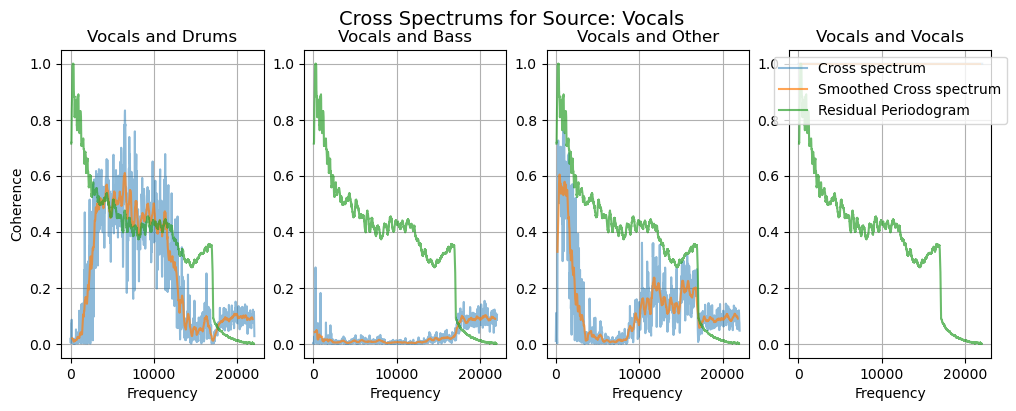

In [2]:
display.display_co_per()

Looking at these plots it appears a number of different sources residuals are correlated to their cross spectrums of other sources. This heavily suggests that the residuals were mostly being caused by contested frequencies in different sources. From this information it allowed me to understand much more thoroughly how some of my MSS models work and also just how audio signal processing works in general. Again I highly reccomend looking over my residual_analysis report to get more detail about each step in my analysis and how I came to my conclusions.

### 4.3 Results of Neural Network

The performance of the model outputs was less than what I had wished, but generally I am happy that the model appears to be in working order and is attempting to isolate the correct sources from the mixture. Of course the outputs, have a massive amount of interference coming in from other sources so the model appears to be not cutting out enough overall. I think to improve this I could try to make my data be trained in the model in a more optimized format or I could try to introduce things to take out more from the model output, possibly things like dropout to the model could feasibly improve performance. Though if I am going to be completely honest, I am proud that the model is working at all, wrapping my head around the complicated structure of the model and coding it all from scratch in Tensorflow when the original model was made in PyTorch, was very much a tough endeavour all to itself.

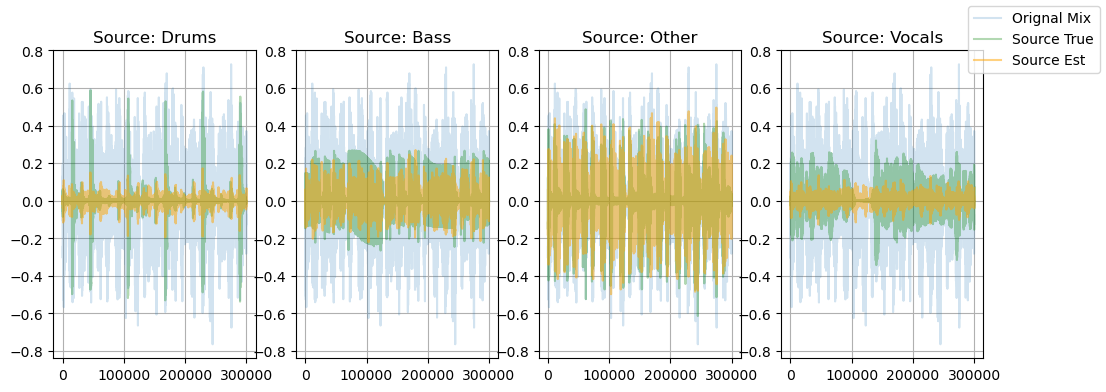

In [2]:
display.display_nn_est()

Looking over the generated sources in comparison to their targets, it is clear the model is attempting to generate the correct signals. Especially looking at the bass estimation it appears quite close to the target, but then looking at something like the drums estimation its clear there is a lot of work that need to be done for the model still. Of course, please check out the model_report for more information if you are interested.

## Conclusion

In the end I am really happy with how my project went, I think there are a number of things I wish I could improved on and made better, but I my objective with this project was always to just learn more about audio processing, time series, and neural networks and in all three of those respects I improved greatly! 

I also want to take this oppurtunity to thank Professor Ichiba for his help and guidance throughout the project, I learned a lot from this project and I would not have been able to do a lot of it without him. 

In the future I would like to do more research into building more advanced machine learning models that process audio data, however I would be very interested in one with a whole objective like automatic music transcription or creating a music recommendation system. Improvement wise I would like make my SARIMA and neural network model work a bit better, as I was a little disappointed with how they performed overall, though I am happy that they are functioning. I am looking forward to doing more research, and cannot wait to learn more and test my skills!

